In [1]:
#Making a subset and import library
import os
import numpy as np
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import json
from panopticapi.utils import rgb2id
import shutil
from torch.cuda.amp import autocast, GradScaler
BATCH_SIZE = 8
IMG_WIDTH = 128
IMG_HEIGHT = 128

TRAIN_PATH ='./data/ADE20K_subset/train'
TEST_PATH ='./data/ADE20K_subset/validation'


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42



In [2]:
# print("TRAIN_PATH exists:", os.path.exists(TRAIN_PATH))
# print(os.listdir(TRAIN_PATH))
# print("TEST_PATH exists:", os.path.exists(TEST_PATH))

# import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is available! GPU count: 1
Current GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
class ADE20KDataset(Dataset):
    def __init__(self, root_dir, transforms=None, img_size=(128, 128)):
        """
        root_dir: path to either training or validation subset folder
                  (containing subfolders or images in the format: *.jpg, *_seg.png)
        transforms: optional data augmentations for the image
        img_size: (width, height) for resizing
        """
        self.root_dir = root_dir
        self.transforms = transforms
        self.img_width, self.img_height = img_size

        # 1) Recursively find all .jpg files
        self.image_files = []
        for root, dirs, files in os.walk(self.root_dir):
            for fname in files:
                if fname.lower().endswith(".jpg"):
                    full_path = os.path.join(root, fname)
                    self.image_files.append(full_path)

        # 2) Sort for consistency
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Returns (img_tensor, mask_tensor).
        mask_tensor is loaded from matching filename:
          e.g. "ADE_train_00001472.jpg" -> "ADE_train_00001472_seg.png"
        """
        img_path = self.image_files[idx]
        # A) Load the RGB image
        img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise FileNotFoundError(f"Could not read image file: {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # B) Build the label path
        base, _ = os.path.splitext(img_path)
        seg_path = base + "_seg.png"  
        # If there's a chance the mask could be named differently (e.g. `_parts_1.png`),
        # ADAPT THE CODE!!! But my job now is just for semantic segmentation :D
        
        mask = cv2.imread(seg_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            raise FileNotFoundError(f"Could not find label file: {seg_path}")

        # C) Resize
        img_rgb = cv2.resize(img_rgb, (self.img_width, self.img_height), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)

        # D) Convert to Tensors
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float()  # [3,H,W], float
        mask_tensor = torch.from_numpy(mask).long()                      # [H,W], int64

        # E) If you have transforms for data augmentation
        if self.transforms is not None:
            # Typically you apply transforms to both the image and the mask,
            # but PyTorch transforms often only handle images. For advanced
            # consistent transforms, you'll need a custom approach or albumentations.
            img_tensor = self.transforms(img_tensor)

        return img_tensor, mask_tensor

In [11]:
train_dataset = ADE20KDataset(
    root_dir = TRAIN_PATH,         
    transforms= None,
    img_size=(IMG_HEIGHT, IMG_WIDTH) # e.g. (128, 128)
)

val_dataset = ADE20KDataset(
    root_dir = TEST_PATH,          
    transforms=None,
    img_size=(IMG_HEIGHT, IMG_WIDTH) #(128,128)
)

#train_loader is a PyTorch DataLoader object that wraps your training dataset (e.g., train_dataset) so you can iterate
# over the data in minibatches for later use.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np


def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    # ^ Picks a random index between 0 and len(dataset)-1.

    image, mask = dataset[idx]
    # ^ Retrieves the (image, mask) pair from the dataset.

    if isinstance(image, torch.Tensor): #In short, PyTorch Tensor wants [C,H,W] but displaying tool like matlabplot wants
                                        #[H,W,C], so we convert it to display purpose
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np, 0, 255).astype(np.uint8)
        """
        Below is an error!!!! Remember I convert pytorch tensor to float before? 
        matplotlib expects that:

        If your image array is an integer type (uint8), the valid range is [0..255].
        If your image array is a float type, the valid range is [0..1].
        现在tensor是float但是却in range 0 to 255，2种解决办法
        """
        #if image_np.max() <= 1.0: # If pixel values are in [0,1], scale them to [0,255] for proper plotting.
            #image_np = (image_np * 255).astype(np.uint8)
    else:
        # If the dataset returned a NumPy array, just rename it image_np.
        image_np = image
        
    # Plot the image on the left
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)   # Show the image in RGB format
    plt.title("Image")

    # Plot the segmentation mask on the right
    plt.subplot(1, 2, 2)
    # If 'mask' is a tensor, move it to CPU and make a NumPy array
    plt.imshow(mask.cpu().numpy() if isinstance(mask, torch.Tensor) else mask)
    plt.title("Mask")

    plt.show()


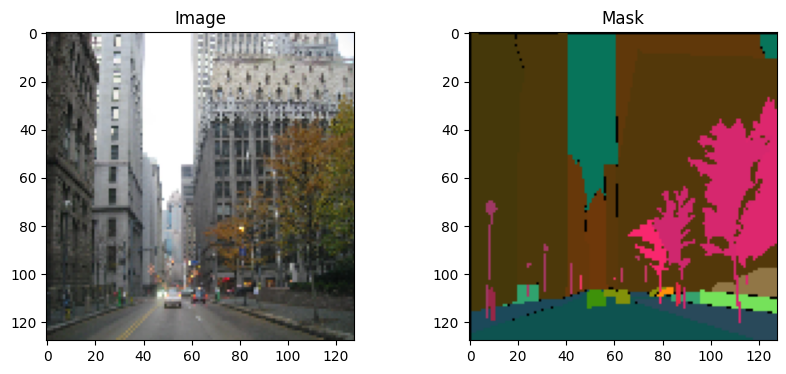

In [6]:
visualize_random_sample(train_dataset)

In [7]:
def mean_iou(y_pred, y_true, num_classes, smooth=1e-6):
    
    y_pred = torch.softmax(y_pred/0.5, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)

    iou_list = []

    for class_id in range(num_classes):
        intersection = torch.sum((y_pred == class_id) & (y_true == class_id))
        union = torch.sum((y_pred == class_id) | (y_true == class_id))
        
        if union == 0:
            continue 
        
        iou = (intersection.float() + smooth) / (union.float() + smooth)
        iou_list.append(iou)


    return torch.mean(torch.stack(iou_list))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Mask2FormerAttention(nn.Module):
    def __init__(self, channels, size):
        super(Mask2FormerAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)
        self.mask = None  
        self.norm = nn.LayerNorm([channels])

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        if channels != self.channels:
            raise ValueError("Input channel size does not match initialized channel size.")
        
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  

        Q = self.query(x)  
        K = self.key(x)    
        V = self.value(x)  

        scores = torch.matmul(Q, K.transpose(-2, -1))  
        scores = scores / (self.channels ** 0.5)       

        if self.mask is None or self.mask.size(-1) != height * width:
            binary_mask = torch.randint(0, 2, (batch_size, height, width), device=x.device)
            binary_mask = binary_mask.view(batch_size, -1)  
            processed_mask = torch.where(binary_mask > 0.5, torch.tensor(0.0, device=x.device), torch.tensor(-float('inf'), device=x.device))
            self.mask = processed_mask.unsqueeze(1).expand(-1, height * width, -1) 
            
        scores = scores + self.mask

        attention_weights = F.softmax(scores, dim=-1)  
        attention_output = torch.matmul(attention_weights, V) 
        attention_output = attention_output + x  
        attention_output = self.norm(attention_output)
        
        return attention_output.view(batch_size, channels, height, width)


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
            nn.BatchNorm2d(out_channels)
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x
    
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = Mask2FormerAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = Mask2FormerAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = Mask2FormerAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)
        
        self.dropout = nn.Dropout(0.3)
        
        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = Mask2FormerAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = Mask2FormerAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = Mask2FormerAttention(64, 64)
        self.norm = nn.LayerNorm([64, 128, 128])
        # self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)
        self.final_layer = nn.Sequential(
                                nn.Conv2d(64, c_out, kernel_size=1),
                                nn.BatchNorm2d(c_out), 
                                nn.ReLU()  
                            )

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        x = self.dropout(x)
        x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        x = self.dropout(x)
        x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        x = self.self_attention6(x)
        x = self.norm(x)
        # output = self.output_conv(x)
        output = self.final_layer(x)
        return output

#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')

In [12]:
import torch.backends.cudnn as cudnn
from torch_lr_finder import LRFinder

c_in = 3  # input channel 3 for RGB
c_out = 19 #Do some research online~

model = UNet(c_in, c_out)
checkpoint_path = "../checkpoint/checkpoint.pth"
print("TRAIN_PATH exists:", os.path.exists(checkpoint_path))
# for module in model.modules():
#     if hasattr(module, "mask"):
#         module.mask = None
#print(os.path.exists(checkpoint_path))

#GPU usage:
device_count = torch.cuda.device_count()
if device_count == 0:
    raise RuntimeError("Bro stop training u won't make it")
elif device_count == 1:
    print("Single GPU....Good Luck")
    device = torch.device("cuda:0")
    model.to(device)
else:
    print(f"Using {device_count} GPUs with DataParallel, COOL! If Paul is buying more GPUs ill be more happy QwQ")
    device = torch.device("cuda:0")
    model = torch.nn.DataParallel(model)
    model.to(device)


#Loading checkpoint
print("Hi1")
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model_dict = model.state_dict()#For current model's State dictionary, Every PyTorch module has a one mapping layer names → parameters.
pretrained_dict = {} # We will store only the checkpoint's layers that MATCH our current model's shape

for k, v in checkpoint.items():
    # Only load layers that have the SAME of both the name and shape
    if k in model_dict and v.shape == model_dict[k].shape:
        pretrained_dict[k] = v
    else:
        print(f"Skipping layer {k} due to shape mismatch: {v.shape} != {model_dict.get(k, None)}")

model_dict.update(pretrained_dict) # Update the model's state dict with filtered, matched weights 
model.load_state_dict(model_dict, strict = False)  # Finally, load that updated dictionary into the model.
for module in model.modules():
    if hasattr(module, "mask"):
        module.mask = None

cudnn.benchmark = True

#Loss, optimizer...

#print(torch.unique(labels))
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=5e-4, 
    steps_per_epoch=len(train_loader),
    epochs=400
)
early_stopping = EarlyStopping(patience=10, verbose=True)

TRAIN_PATH exists: True
Single GPU....Good Luck
Hi1
Skipping layer module.initial_conv.conv_block.0.weight due to shape mismatch: torch.Size([64, 3, 3, 3]) != None
Skipping layer module.initial_conv.conv_block.1.weight due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.bias due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.running_mean due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.running_var due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.1.num_batches_tracked due to shape mismatch: torch.Size([]) != None
Skipping layer module.initial_conv.conv_block.3.weight due to shape mismatch: torch.Size([64, 64, 3, 3]) != None
Skipping layer module.initial_conv.conv_block.4.weight due to shape mismatch: torch.Size([64]) != None
Skipping layer module.initial_conv.conv_block.4.bias due to shape mismatch: torch.Siz

In [13]:
for i, (inputs, labels) in enumerate(train_loader):
    unique_vals = labels.unique()
    print("Unique labels in this batch:", unique_vals)
    break  # just break after the first batch for debugging
print("Number of unique labels:", unique_vals.numel())
#Clear Memory

torch.cuda.empty_cache()




Unique labels in this batch: tensor([  0,   3,  10,  12,  15,  17,  18,  20,  24,  25,  30,  31,  36,  38,
         39,  40,  41,  43,  45,  47,  48,  49,  50,  51,  55,  56,  57,  60,
         61,  70,  71,  73,  75,  77,  80,  82,  84,  85,  90,  91,  92,  94,
         97, 100, 101, 102, 105, 109, 110, 112, 116, 118, 120, 121, 122, 128,
        131, 133, 134, 135, 139, 143, 145, 146, 149, 150, 153, 158, 162, 163,
        164, 165, 166, 169, 170, 173, 174, 177, 180, 182, 184, 189, 194, 195,
        199, 200, 204, 206, 208, 210, 213, 214, 219, 224, 225, 228, 231, 235,
        236, 237, 239, 240, 243, 245, 247, 252, 253, 255])
Number of unique labels: 108


In [14]:
# Training loop

num_epochs = 500
best_loss = float("inf")
best_iou = 0.0

log_file = open("training_log_backend.txt", "w")
scaler = torch.amp.GradScaler()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # -- Mixed Precision context --
        with torch.amp.autocast("cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # -- Scale loss before backward --
        scaler.scale(loss).backward()

        # -- Step optimizer with scaled gradients --
        scaler.step(optimizer)
        scaler.update()

        # -- compute IoU (already in FP32 in your mean_iou function) --
        iou = mean_iou(outputs, labels, c_out)

        total_loss += loss.item()
        total_iou += iou.item()

        # Debug checkpoint every so often
        if i % 500 == 0 and i != 0:
            avg_so_far_loss = total_loss / (i+1)
            avg_so_far_iou  = total_iou  / (i+1)
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] "
                  f"Loss: {avg_so_far_loss:.4f} IoU: {avg_so_far_iou:.4f}")
            if i % 200 == 0:
                print("Saving intermediate model checkpoint...")
                torch.save(model.state_dict(), 'checkpoint_intermediate.pth')

    # End of epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_iou  = total_iou  / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")

    # Track best
    best_loss = min(best_loss, avg_loss)
    best_iou  = max(best_iou,  avg_iou)

    # Overfit detection? (Your code)
    if best_iou - avg_iou > 0.1:
        print("Model Overfitting: difference in best_iou vs. current_iou > 0.1.")
        break

    # step the scheduler
    scheduler.step()

    # save epoch checkpoint
    torch.save(model.state_dict(), 'epoch_latest.pth')

    # log
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} IoU: {avg_iou:.4f}\n")
    log_file.write(f"Best loss: {best_loss:.4f}, Best IoU: {best_iou:.4f}\n\n")
    log_file.flush()

    # early stopping
    if early_stopping(avg_loss, model):
        print("Early stopping triggered!")
        break

log_file.close()
print(f"Best loss = {best_loss:.4f}, best iou = {best_iou:.4f}")

  0%|          | 0/47 [00:28<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model = model.to(device)
best_val_loss = float("inf")
best_val_iou = 0.0
log_file = open("validating_log_trail2.txt", "w")
for epoch in range(0,num_epochs):
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            # inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_val_iou += mean_iou(outputs, labels,c_out).item()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    preds_val = outputs

    avg_val_loss = total_val_loss / num_batches
    avg_val_iou = total_val_iou / num_batches

    print(f"Validation Loss: {avg_val_loss}, Validation IoU: {avg_val_iou}")
    
    best_val_loss = min(best_val_loss,avg_val_loss)
    best_val_iou = max(best_val_iou,avg_val_iou)
    
    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_val_loss} IoU: {avg_val_iou}\n")
    log_file.write(f'Best loss: {best_val_loss}, Best IoU: {best_val_iou}\n\n')
    log_file.flush()

print(f'Best Validation loss is {best_val_loss}, best Validation iou is {best_val_iou}')
log_file.close()

100%|██████████| 625/625 [03:04<00:00,  3.38it/s]


Validation Loss: 4.136365626144409, Validation IoU: 0.017687656047940255


 17%|█▋        | 105/625 [00:30<02:33,  3.40it/s]


KeyboardInterrupt: 

In [62]:
def visualize_predictions(model, dataset, device, idx=0):
    model.eval()
    with torch.no_grad():
        image, mask = dataset[idx] 
        image = image.unsqueeze(0).to(device)  
        
        output = model(image)
        print(output.shape)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask)
        plt.title("Predicted Mask")

        plt.show()


torch.Size([1, 133, 128, 128])


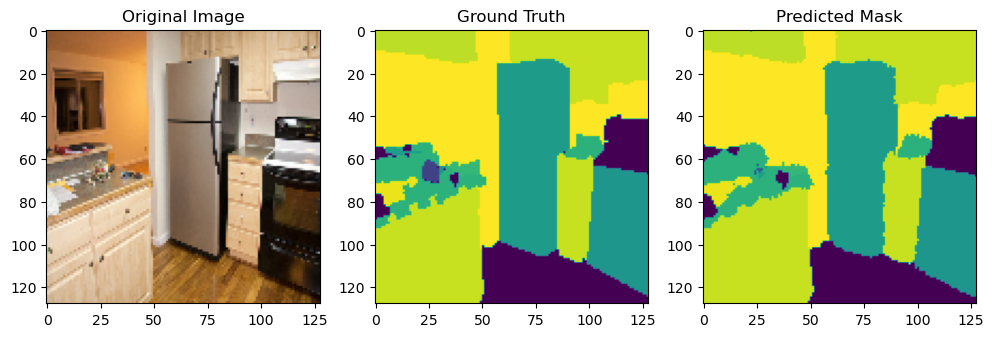

In [ ]:
test_idx = random.randint(0, len(train_dataset) - 1)
visualize_predictions(model, train_dataset, device, idx=test_idx)